# Comparing by critical lifetime ratio (PHASOR part)
Simulating the lifetime decay from 3.07 to 2.5, for 20 points. Amplitude the same as before. Derive the index of separability to obtain critical
lifetime ratio.

In [2]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import convolve
from scipy import stats
from sympy import symbols, solve, Eq, Function, nsolve
from sympy.matrices import Matrix
import sympy as sp
from scipy.optimize import curve_fit
from lmfit import Model, Parameters
import lmfit
import inspect
import pandas as pd
import numdifftools
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.optimize import fsolve
from TCSPC import *
plt.rcParams['figure.constrained_layout.use'] = True
plt.style.use('seaborn-v0_8-deep')

In [3]:
# define functions from phasor.ipynb
def phasor_eq_func_A_vary(A_tau_arr,phasor):
    '''Function to be passed to phasor_solve_num to solve for A_tau array (A1,A2, tau1, tau2)
       Input: 
       A_tau_arr    parameter array A1,A2 tau1, tau2
       phasor       phasor array from Simulation().phasor to be resolved '''
    n = int(len(A_tau_arr)/2) #number of components
    y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n]) for j in range(n)]) #pure multiexponential
    y = np.convolve(y,EGFP.ker,'full')[:EGFP.n_bins]/np.sum(EGFP.ker)
    w,phasor_test = EGFP.phasor_fft(y=y) 
    A_sum = 1-np.sum(A_tau_arr[:n]) #A1,...An sum to 1
    phasor_compare = phasor_test.real[:2*n-1]-phasor.real[:2*n-1] #solve for A_tau_arr such that it gives 0
    return [A_sum]+list(phasor_compare) #

def phasor_eq_func(A_tau_arr,phasor):
    '''Function to be passed to phasor_solve_num to solve for A_tau array (A1, tau1, tau2) (2n-1)
       Input: 
       A_tau_arr    parameter array A1 tau1, tau2
       phasor       phasor array from Simulation().phasor to be resolved '''
    n = int((len(A_tau_arr)+1)/2) #number of components
    #A_tau_arr = np.insert(A_tau_arr,n-1,1-np.sum(A_tau_arr[:n-1])) #insert An
    y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential
    y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-EGFP.t / A_tau_arr[-1]) #last component
    y  = np.convolve(y,EGFP.ker,'full')[:EGFP.n_bins]/np.sum(EGFP.ker)
    w,phasor_test = EGFP.phasor_fft(y=y) 
    return phasor_test.real[:2*n-1]-phasor.real[:2*n-1] #solve for A_tau_arr such that it gives 0
    

def phasor_solve_num(phasor,x0):
    '''Solve for amplitude and lifetimes numerically using 3 phasors for 3 parameters (A1, tau1, tau2)
       phasor      phasor array (Simulation().phasor) to be resolved
       x0          initial guess for a_tau_arr'''
    return fsolve(phasor_eq_func,x0=x0,args = phasor)

In [3]:
# simulation for different lifetimes
tau_array = np.linspace(2.43,3.07,20)
par_arr = np.zeros((20,100,3))
for i in range(len(tau_array)):
    tau2 = tau_array[i]
    EGFP = Phasor([0.497,0.503],[2.43,tau2])
    for j in range(len(EGFP.phasor_data)): #no background
        phasor = EGFP.phasor_data[j]
        par_arr[i,j] = phasor_solve_num(phasor,[EGFP.amp[0],*EGFP.tau])

C:\Users\xujia\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\xujia\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [4]:
# calculate means and standard deviations
mean = np.mean(par_arr,axis = 1)
std = np.std(par_arr,axis = 1)

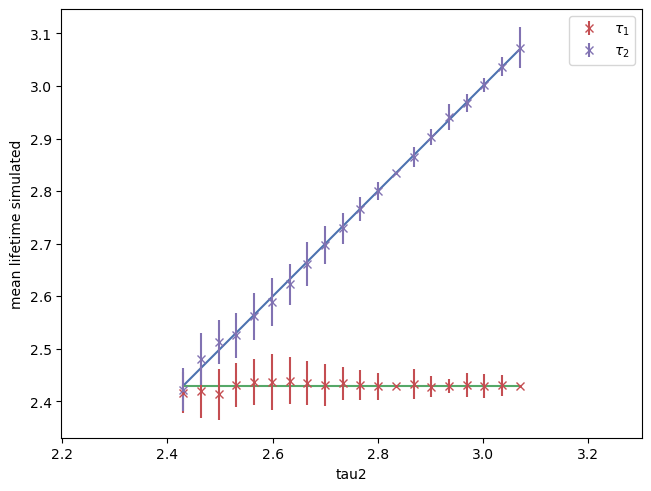

In [5]:
# plot 1D graph for simulated data
plt.figure()
plt.axis("equal")
plt.plot(tau_array,tau_array)
plt.plot([2.43,3.07],[2.43,2.43])
plt.errorbar(tau_array,mean[:,1],yerr=std[:,1],fmt = 'x',label=rf'$\tau_{1}$')
plt.errorbar(tau_array,mean[:,2],yerr=std[:,2],fmt = 'x',label=rf'$\tau_{2}$')

plt.xlabel("tau2")
plt.ylabel("mean lifetime simulated")
plt.legend()
plt.show()

## Simulation for lifetimes

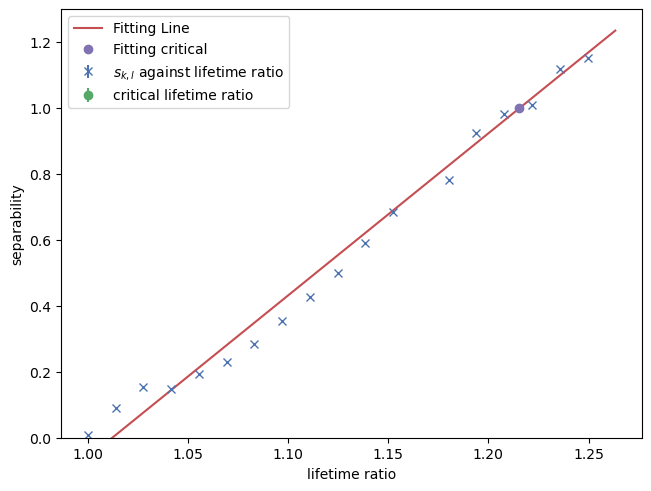

The critical lifetime ratio is 1.2155077941895545, corresponding to 2.9536839398806176s.


<Figure size 640x480 with 0 Axes>

In [24]:
# plot lifetime ratio
tau_ratio = tau_array/2.43
critical_tau_ratio_0 = np.full(20, np.nan)
critical_s_0 = np.full(20, np.nan)
separability_0 = abs(mean[:,1]-mean[:,2]) / (np.sqrt(std[:,1])+np.sqrt(std[:,2]))**0.5
whether_1st_cri = 0
for i in range(20):
    if separability_0[i] < 1 or whether_1st_cri != 0: 
        pass
    else:
        critical_tau_ratio_0[i] = tau_ratio[i]
        critical_s_0[i] = separability_0[i]
        whether_1st_cri += 1

# 使用非零的 tau_ratio 和对应的 tau_array
valid_indices = separability_0 < 2
x_fit = tau_ratio[valid_indices]
y_fit = separability_0[valid_indices]

# 使用 numpy 的 polyfit 进行线性拟合，1 表示线性（即一次多项式）
coefficients = np.polyfit(x_fit, y_fit, 1)
# 使用拟合的系数生成拟合直线的 y 值
y_line = np.polyval(coefficients, tau_ratio)

x_intersect = (1 - coefficients[1]) / coefficients[0]

plt.figure()
plt.errorbar(tau_ratio,separability_0,yerr=0,fmt = 'x',label="$s_{k,l}$ against lifetime ratio")
plt.errorbar(critical_tau_ratio_0,critical_s_0,yerr=0,fmt = 'o',label="critical lifetime ratio")
plt.plot(tau_ratio, y_line, label="Fitting Line")
plt.plot(x_intersect, 1, 'o', label="Fitting critical")

plt.ylim(0,1.3)
plt.xlabel("lifetime ratio")
plt.ylabel("separability")
plt.legend()
plt.show()

print(f"The critical lifetime ratio is {x_intersect}, corresponding to {2.43*x_intersect}s.")
plt.savefig('s_kl.pdf', format='pdf')

## Comparing performance with different angular frequency

In [5]:
# discuss the behavior of phasor_solve_num for different angular frequency
def phasor_eq_func_w(A_tau_arr,phasor):
    '''Function to be passed to phasor_solve_num to solve for A_tau array (A1, tau1, tau2) (2n-1)
       Input: 
       A_tau_arr    parameter array A1 tau1, tau2
       phasor       phasor array from Simulation().phasor to be resolved
       x            the initial angular frequency'''
    n = int((len(A_tau_arr)+1)/2) #number of components
    #A_tau_arr = np.insert(A_tau_arr,n-1,1-np.sum(A_tau_arr[:n-1])) #insert An
    y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential
    y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-EGFP.t / A_tau_arr[-1]) #last component
    y = np.convolve(y,EGFP.ker,'full')[:EGFP.n_bins]/np.sum(EGFP.ker)
    w,phasor_test = EGFP.phasor_fft(y=y) 
    phasor_compare = phasor_test.real[sec_i:2*n-1+sec_i]-phasor.real[sec_i:2*n-1+sec_i] #solve for A_tau_arr such that it gives 0
    return phasor_compare

def phasor_solve_num_w(phasor,x0):
    '''Solve for amplitude and lifetimes numerically using 3 phasors for 3 parameters (A1, tau1, tau2)
       phasor      phasor array (Simulation().phasor) to be resolved
       x0          initial guess for a_tau_arr'''
    return fsolve(phasor_eq_func_w,x0=x0,args=(phasor))

def plot_w(x,sec_i):
    '''
    calculate the paras and plot the graph for different angular frequency
    input:
    x     par_arr
    output:
    INDEX_i                    angular frequency selection
    separability_kl[s_min]     separability
    critical_tau_ratio         critical lifetime ratio
    '''
    # calculate means and standard deviations
    mean = np.mean(x,axis = 1)
    std = np.std(x,axis = 1)
    separability_kl = abs(mean[:,1]-mean[:,2]) / (np.sqrt(std[:,1])+np.sqrt(std[:,2]))**0.5
    tau_ratio = tau_array/2.43

    # 使用非零的 tau_ratio 和对应的 tau_array
    valid_indices = separability_kl < 1.3
    x_fit = tau_ratio[valid_indices]
    y_fit = separability_kl[valid_indices]
    coefficients = np.polyfit(x_fit, y_fit, 1)
    y_line = np.polyval(coefficients, tau_ratio)
    x_intersect = (1 - coefficients[1]) / coefficients[0]

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"for angular frequency from {sec_i}", fontsize=16)

    axs[0].plot(tau_array, tau_array)
    axs[0].plot([2.43, 3.07], [2.43, 2.43])
    axs[0].errorbar(tau_array, mean[:,1], yerr=std[:,1], fmt='x', label=rf'$\tau_{{1}}$')
    axs[0].errorbar(tau_array, mean[:,2], yerr=std[:,2], fmt='x', label=rf'$\tau_{{2}}$')
    axs[1].errorbar(tau_ratio,separability_kl,yerr=0,fmt = 'x',label="$s_{k,l}$ against lifetime ratio")
    axs[1].plot(x_intersect, 1, 'o', label="critical lifetime ratio")
    axs[1].plot(tau_ratio, y_line, label="Fitting Line")

    axs[0].set_xlabel("tau2")
    axs[0].set_ylabel("mean lifetime simulated")
    axs[0].legend()
    axs[1].set_xlabel("lifetime ratio")
    axs[1].set_ylabel("separability")
    axs[1].legend()

    axs[0].set_xlim(2.4,3.2)
    axs[0].set_ylim(2.4,3.2)
    axs[1].set_xlim(1,x_intersect+0.1)
    axs[1].set_ylim(0,1.3)
    plt.tight_layout()
    plt.show()
    print(f"The critical lifetime ratio is {x_intersect} for selection of {sec_i}. ")
    return x_intersect

In [6]:
INDEX_arr = np.zeros(20)
separation_arr = np.zeros(20)
critical_tau_arr = np.zeros(20)

In [9]:
# simulation for different lifetimes
tau_array = np.linspace(2.43,3.07,20)
par_arr = np.zeros((20,100,3))
par_arr_f = np.zeros((10,20,100,3))
cri_arr = np.zeros(10)
for num in range(10):
    sec_i = num
    for i in range(len(tau_array)):
        tau2 = tau_array[i]
        EGFP = Phasor([0.497,0.503],[2.43,tau2])
        for j in range(len(EGFP.phasor_data)): #no background
            phasor = EGFP.phasor_data[j]
            par_arr[i,j] = phasor_solve_num_w(phasor,[EGFP.amp[0],*EGFP.tau])
    par_arr_f[num] = par_arr

C:\Users\xujia\AppData\Local\Temp\ipykernel_28476\3386848440.py:10: RuntimeWarning: overflow encountered in exp
  y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential
C:\Users\xujia\AAA\TCSPC.py:188: RuntimeWarning: invalid value encountered in divide
  phasor = (np.fft.fft(y).T/y_sum).T
C:\Users\xujia\AppData\Local\Temp\ipykernel_28476\3386848440.py:11: RuntimeWarning: overflow encountered in exp
  y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-EGFP.t / A_tau_arr[-1]) #last component
C:\Users\xujia\AppData\Local\Temp\ipykernel_28476\3386848440.py:11: RuntimeWarning: overflow encountered in multiply
  y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-EGFP.t / A_tau_arr[-1]) #last component
C:\Users\xujia\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\xujia\AppData\Local\Temp\ipykernel_28476\3386848440.py:10: Runti

C:\Users\xujia\AppData\Local\Temp\ipykernel_28476\3386848440.py:69: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


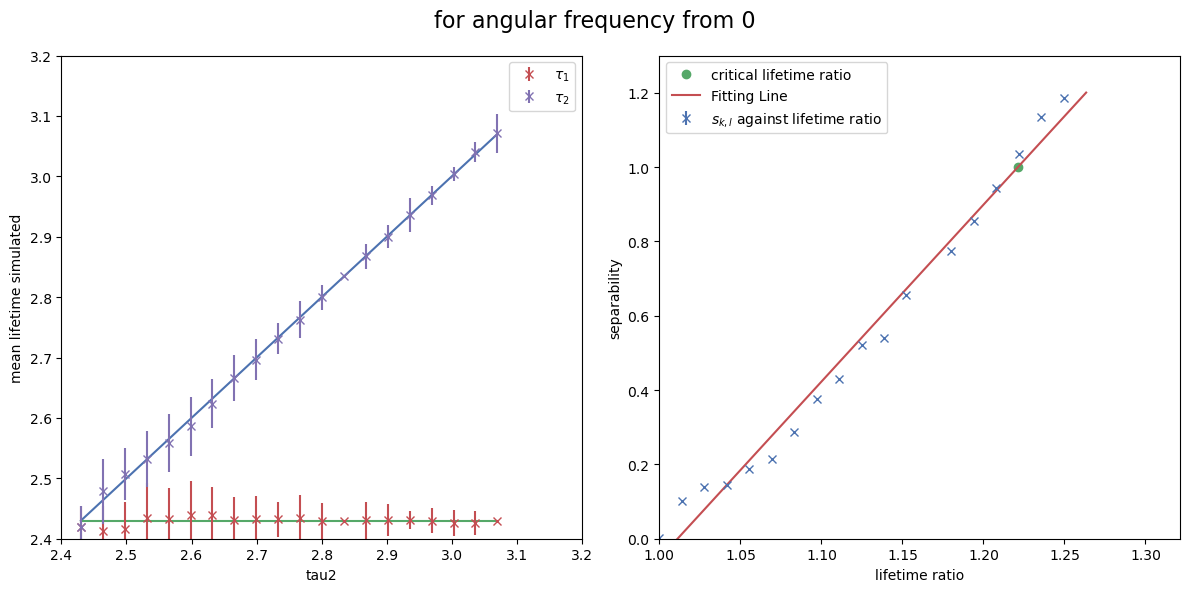

The critical lifetime ratio is 1.2212970681262292 for selection of 0. 


<Figure size 640x480 with 0 Axes>

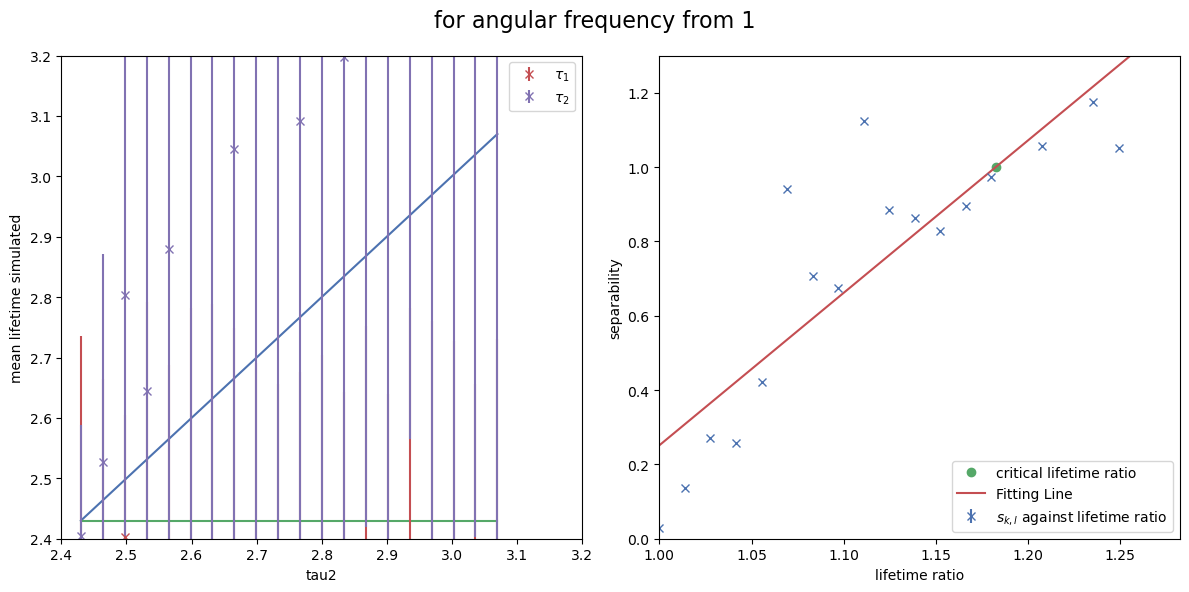

The critical lifetime ratio is 1.182647401621773 for selection of 1. 


<Figure size 640x480 with 0 Axes>

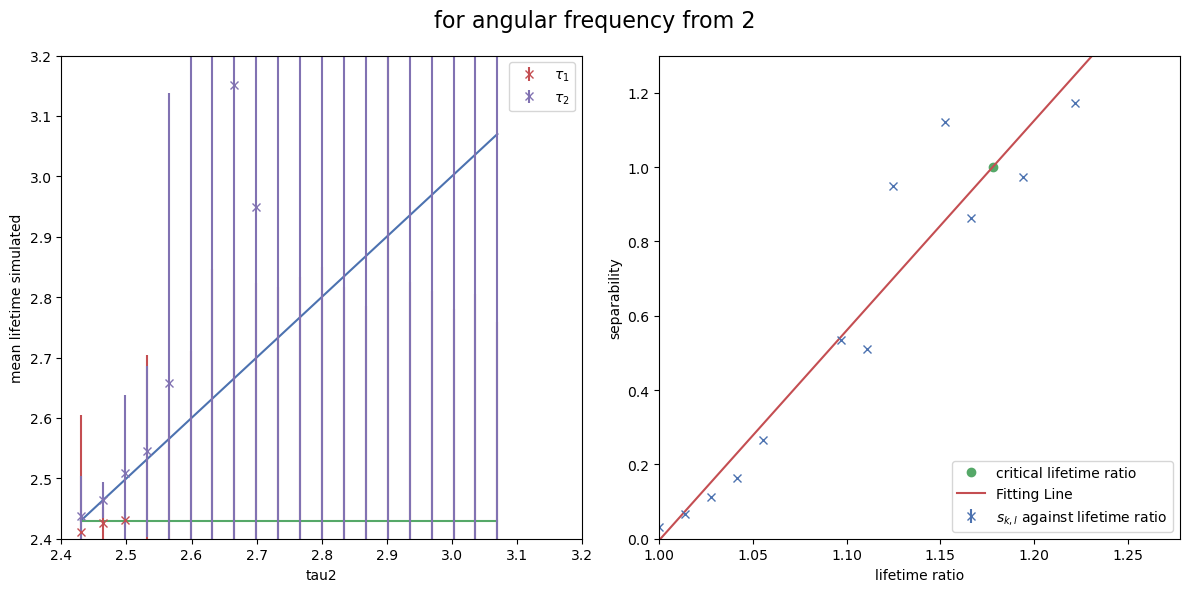

The critical lifetime ratio is 1.1779563930672317 for selection of 2. 


<Figure size 640x480 with 0 Axes>

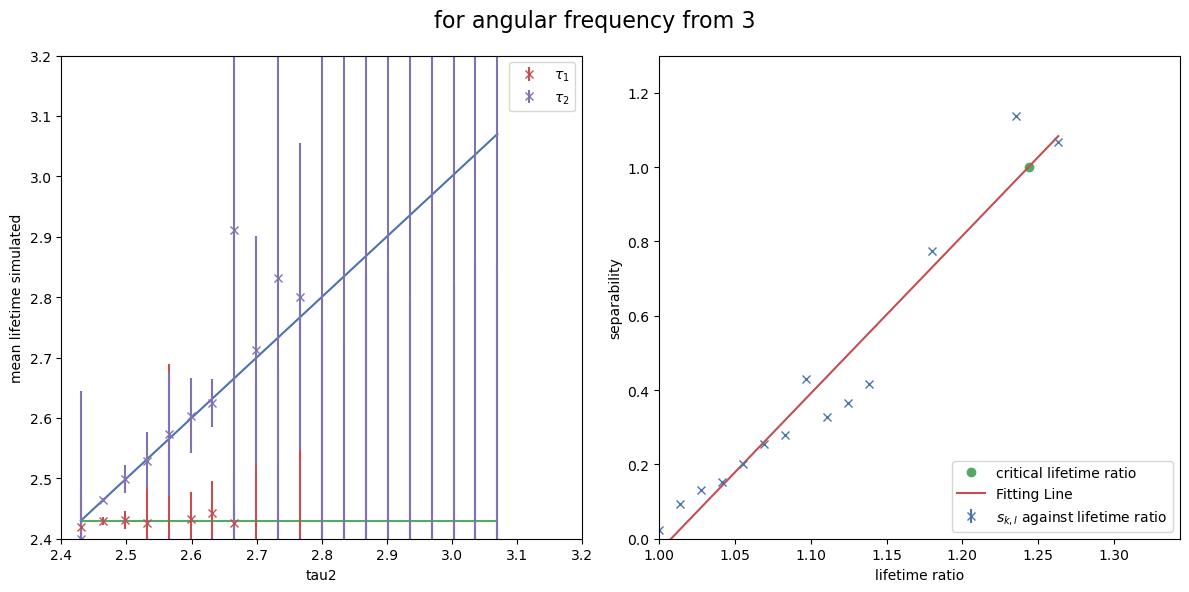

The critical lifetime ratio is 1.2437436234999688 for selection of 3. 


<Figure size 640x480 with 0 Axes>

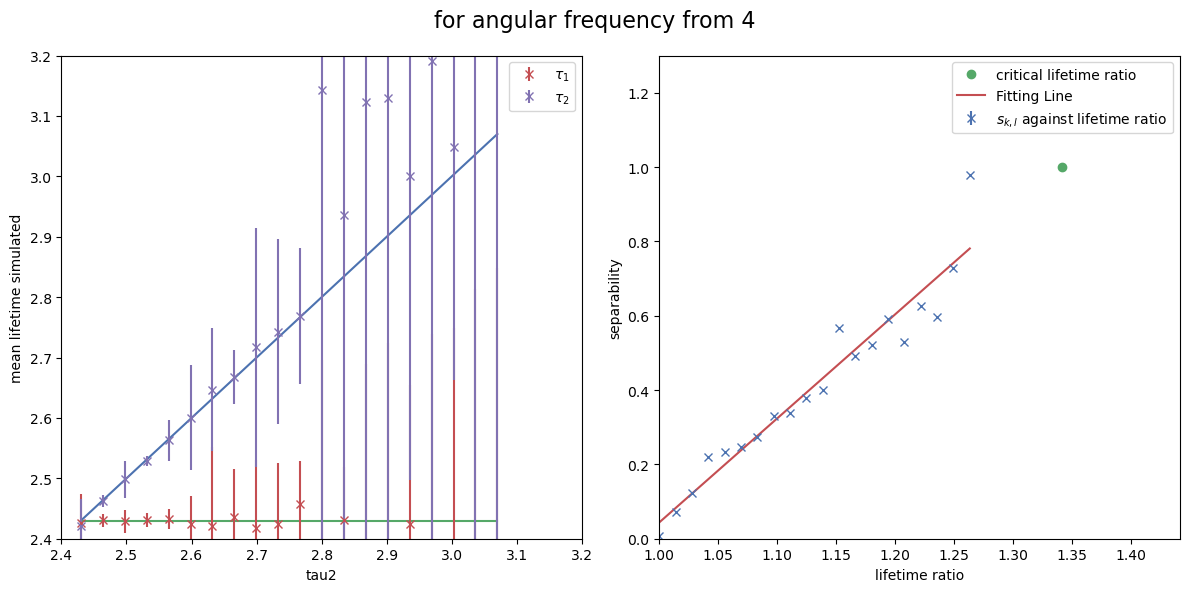

The critical lifetime ratio is 1.3417495922531715 for selection of 4. 


<Figure size 640x480 with 0 Axes>

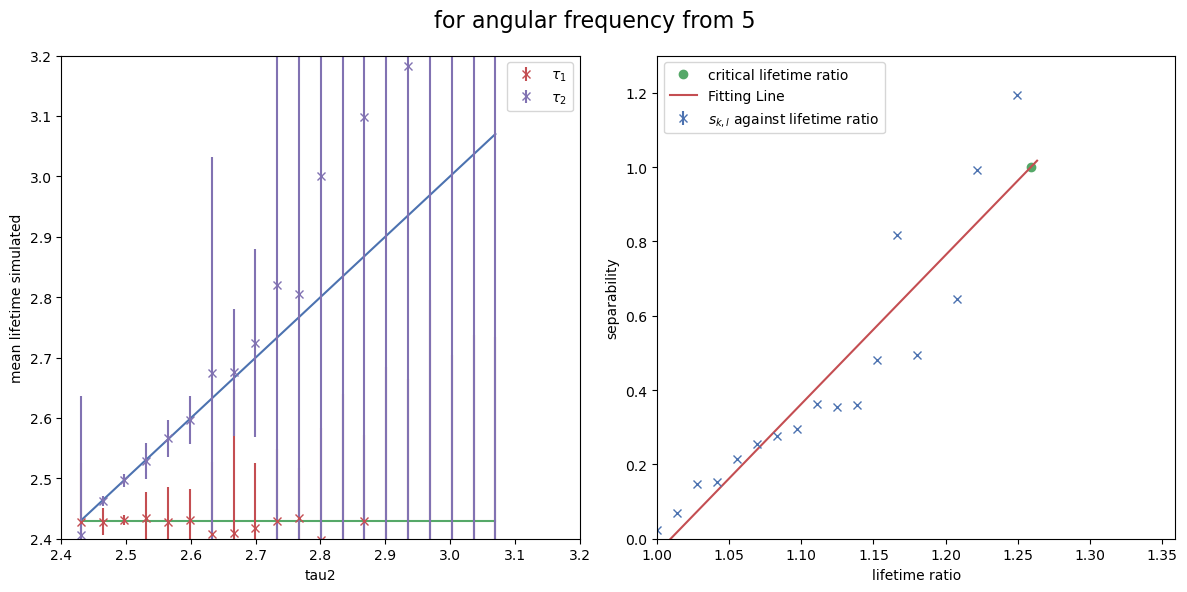

The critical lifetime ratio is 1.2591179590644443 for selection of 5. 


<Figure size 640x480 with 0 Axes>

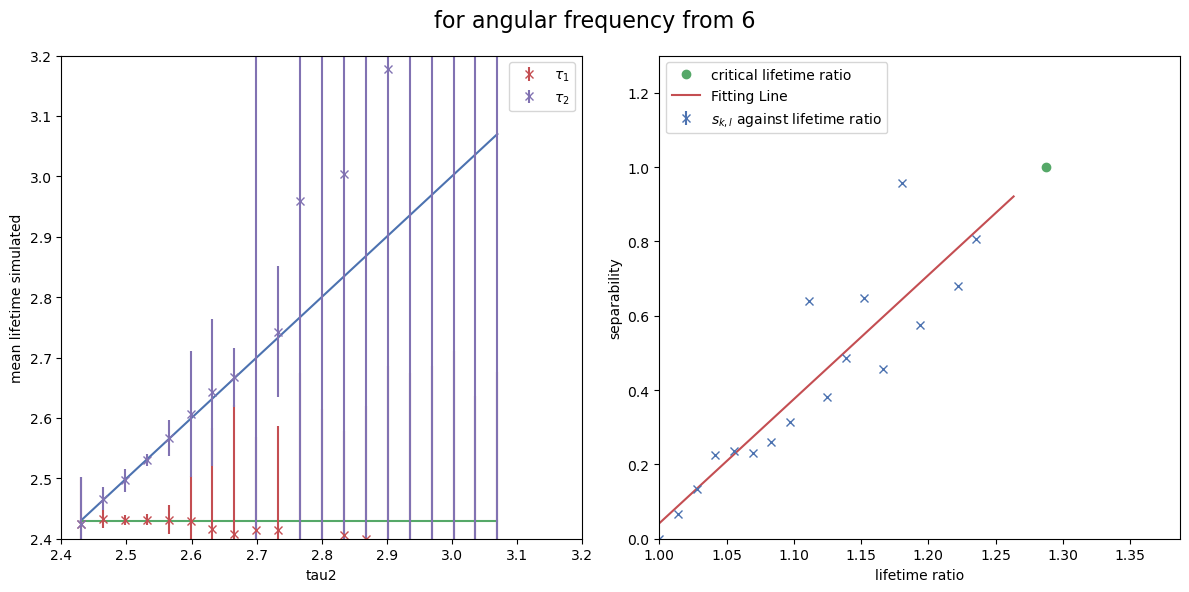

The critical lifetime ratio is 1.2870960106098066 for selection of 6. 


<Figure size 640x480 with 0 Axes>

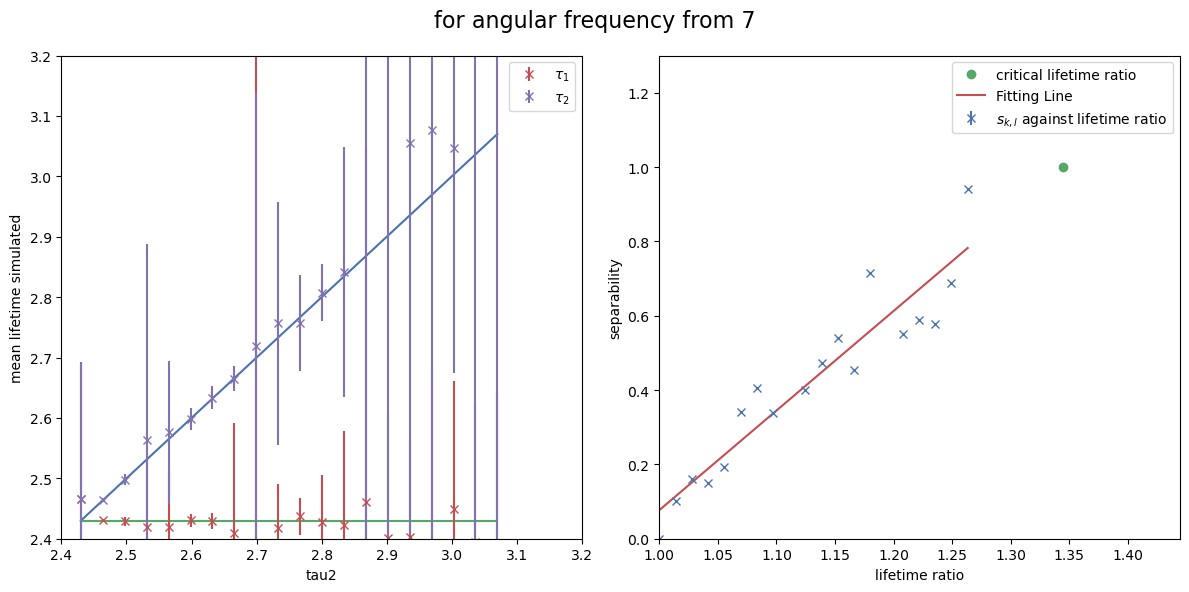

The critical lifetime ratio is 1.3447762132662047 for selection of 7. 


<Figure size 640x480 with 0 Axes>

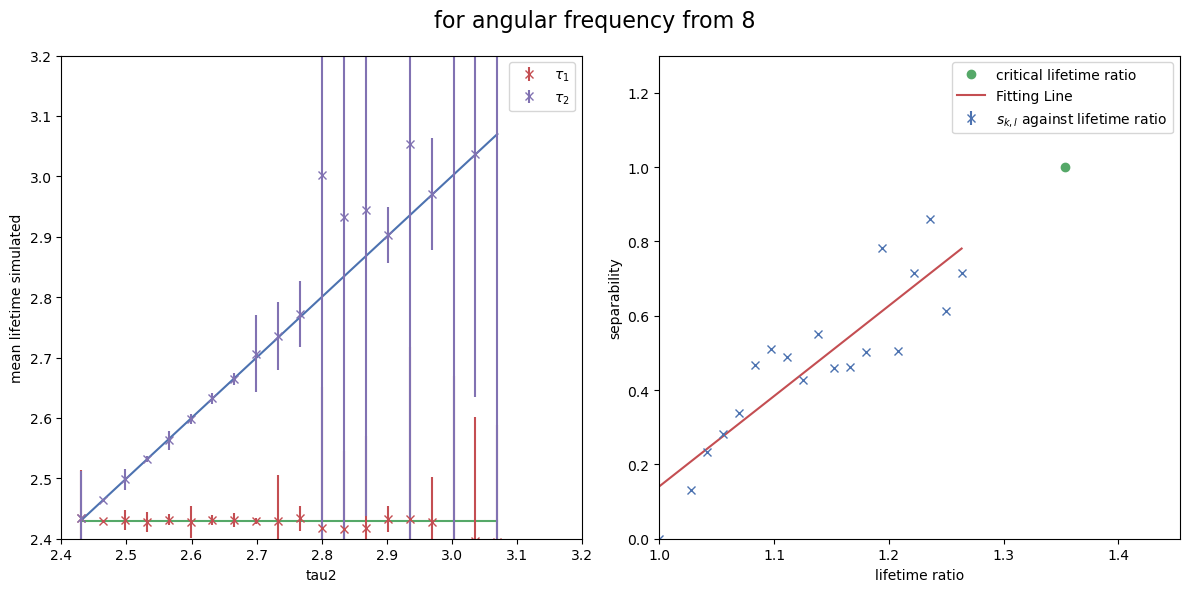

The critical lifetime ratio is 1.3537053343652072 for selection of 8. 


<Figure size 640x480 with 0 Axes>

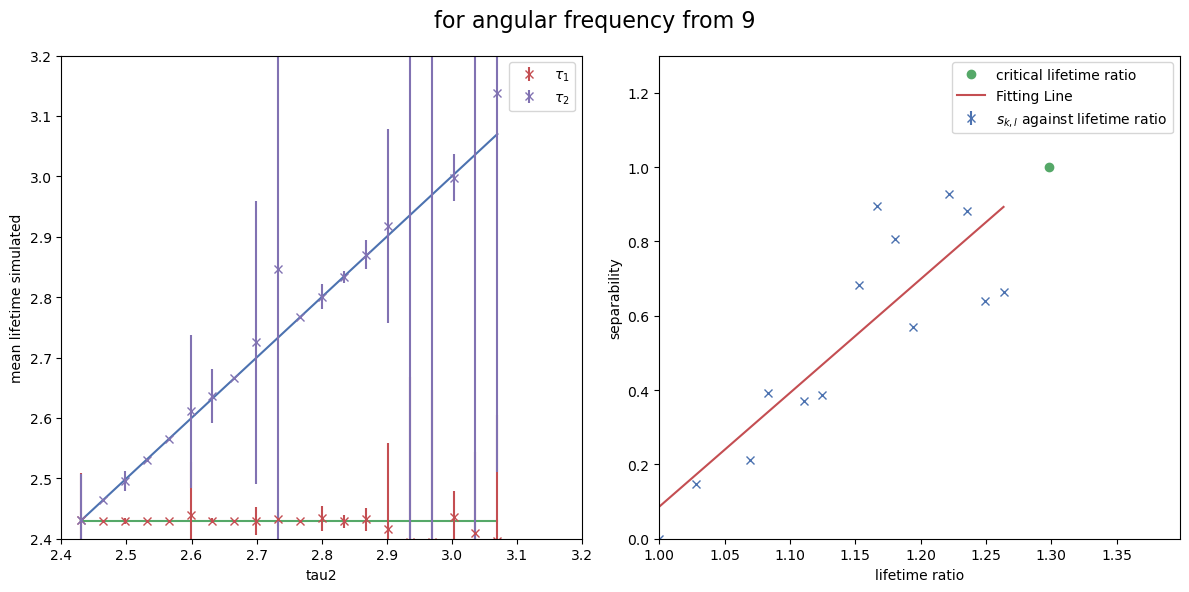

The critical lifetime ratio is 1.298436096958915 for selection of 9. 


<Figure size 640x480 with 0 Axes>

In [25]:
for num in range(10):
    cri_arr[num] = plot_w(par_arr_f[num],num)
    plt.savefig(f's_w{num}.pdf', format='pdf')

mean critical lifetime ratio: 1.2710525692832952.


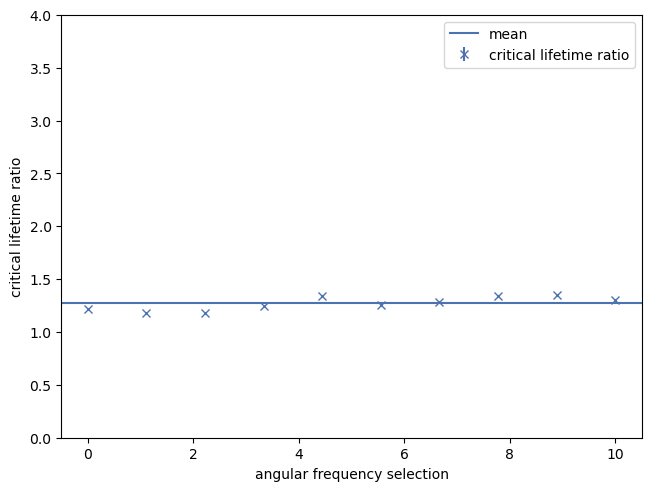

<Figure size 640x480 with 0 Axes>

In [26]:
y_mean = np.mean(cri_arr)
print(f"mean critical lifetime ratio: {y_mean}.")

plt.figure()
plt.ylim(0,4)
plt.axhline(y=y_mean,linestyle='-', label='mean')
plt.errorbar(np.linspace(0,10,10), cri_arr, yerr=0, fmt='x', label="critical lifetime ratio")
plt.xlabel("angular frequency selection")
plt.ylabel("critical lifetime ratio")
plt.legend()
plt.show()
plt.savefig('tau_w.pdf', format='pdf')

## Replot

In [12]:
def plot_sep(x,sec_i):
    '''
    calculate the paras and plot the graph for different angular frequency
    input:
    x     par_arr
    output:
    INDEX_i                    angular frequency selection
    separability_kl[s_min]     separability
    critical_tau_ratio         critical lifetime ratio
    '''
    # calculate means and standard deviations
    mean = np.mean(x,axis = 1)
    std = np.std(x,axis = 1)
    separability_kl = abs(mean[:,1]-mean[:,2]) / (np.sqrt(std[:,1])+np.sqrt(std[:,2]))**0.5

    plt.plot(tau_array, tau_array)
    plt.plot([2.43, 3.07], [2.43, 2.43])
    plt.errorbar(tau_array, mean[:,1], yerr=std[:,1], fmt='x', label=rf'$\tau_{{1}}$ for {sec_i}')
    plt.errorbar(tau_array, mean[:,2], yerr=std[:,2], fmt='x', label=rf'$\tau_{{2}}$ for {sec_i}')
    return x_intersect

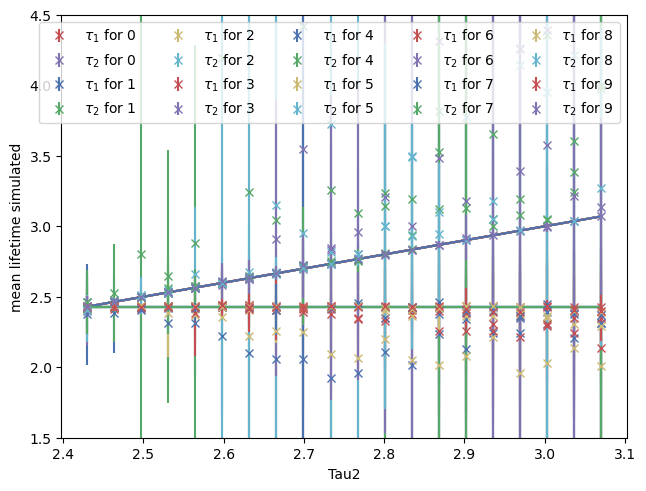

In [13]:
plt.figure()
plt.xlabel("Tau2")
plt.ylabel("mean lifetime simulated")
plt.ylim(1.5,4.5)
for num in range(10):
    plot_sep(par_arr_f[num],num)
plt.axhline(y=1, color='orange', linestyle='-')
plt.style.use('seaborn-v0_8-deep')
plt.legend(ncol=5)
plt.show()

In [14]:
def plot_s_ratio(x,sec_i):
    '''
    calculate the paras and plot the graph for different angular frequency
    input:
    x     par_arr
    output:
    INDEX_i                    angular frequency selection
    separability_kl[s_min]     separability
    critical_tau_ratio         critical lifetime ratio
    '''
    # calculate means and standard deviations
    mean = np.mean(x,axis = 1)
    std = np.std(x,axis = 1)
    separability_kl = abs(mean[:,1]-mean[:,2]) / (np.sqrt(std[:,1])+np.sqrt(std[:,2]))**0.5
    tau_ratio = tau_array/2.43

    # 使用非零的 tau_ratio 和对应的 tau_array
    valid_indices = separability_kl < 1.3
    x_fit = tau_ratio[valid_indices]
    y_fit = separability_kl[valid_indices]
    coefficients = np.polyfit(x_fit, y_fit, 1)
    y_line = np.polyval(coefficients, tau_ratio)
    x_intersect = (1 - coefficients[1]) / coefficients[0]

    plt.errorbar(tau_ratio,separability_kl,yerr=0,fmt = 'x')
    plt.plot(x_intersect, 1, 'o')
    plt.plot(tau_ratio, y_line, label=f"f:{sec_i}")
    return

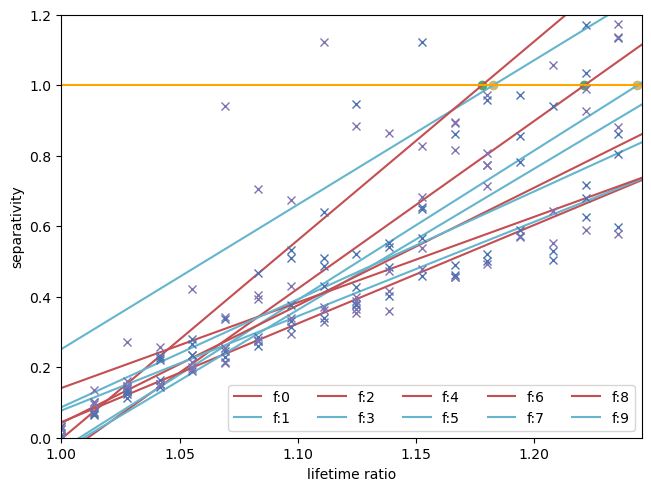

In [15]:
plt.figure()
plt.xlabel("lifetime ratio")
plt.ylabel("separativity")
plt.xlim(1,x_intersect+0.03)
plt.ylim(0,1.2)

for num in range(10):
    plot_s_ratio(par_arr_f[num],num)
plt.axhline(y=1, linestyle='-',color='orange')
plt.legend(ncol=5)
plt.show()

## Discuss behavior if using analytic phasor

In [16]:
# use analytic phasor: assign multi_exp_FT to phasor_test 
# multi_exp_FT(omega,A,tau,n) gives solve for A_tau_arr such that it gives 0

In [17]:
def multi_exp_FT(omega,A,tau):
    '''Analytic solution to Fourier Transform (normalized, i.e. divided by int_0^infty exp(-t/tau)dt) 
    of multi exponential decay with components lifetime tau
    Input:
    omega     angular frequency array
    A         amplitude array
    tau       lifetime'''
    coeff = A*tau/np.sum(A*tau) #coefficient of the sum of mono_exp_FT
    mono_arr = exp_FT(omega,tau)#array of FT of each lifetime
    return np.dot(coeff,mono_arr)

def phasor_eq_func_ana(A_tau_arr,phasor):
    '''Function to be passed to phasor_solve_num to solve for A_tau array (A1, tau1, tau2) (2n-1)
       Input: 
       A_tau_arr    parameter array A1 tau1, tau2
       phasor       phasor array from Simulation().phasor to be resolved '''
    n = int((len(A_tau_arr)+1)/2) #number of components
    A_tau_arr = np.insert(A_tau_arr,n-1,1-np.sum(A_tau_arr[:n-1])) #insert An
    y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n)]) #pure multiexponential
    # y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-EGFP.t / A_tau_arr[-1]) #last component
    y  = np.convolve(y,EGFP.ker,'full')[:EGFP.n_bins]/np.sum(EGFP.ker)
    w,phasor_test = EGFP.phasor_fft(y=y) 
    phasor_test = multi_exp_FT(w,A_tau_arr[0:n],A_tau_arr[n:]) 
    return phasor_test.real[0:2*n-1] #solve for A_tau_arr such that it gives 0
    
def phasor_solve_num_ana(phasor,x0):
    '''Solve for amplitude and lifetimes numerically using 3 phasors for 3 parameters (A1, tau1, tau2)
       phasor      phasor array (Simulation().phasor) to be resolved
       x0          initial guess for a_tau_arr'''
    return fsolve(phasor_eq_func_ana,x0=x0,args = phasor)

In [18]:
# simulation for analytic
tau_array = np.linspace(2.43,3.07,20)
par_arr_ana = np.zeros((20,100,3))
#par_arr_ana_f = np.zeros((10,20,100,3))
#cri_arr_ana = np.zeros(10)
#for num in range(10):
#    sec_i = num
for i in range(len(tau_array)):
    tau2 = tau_array[i]
    EGFP = Phasor([0.497,0.503],[2.43,tau2])
    for j in range(len(EGFP.phasor_data)): #no background
        phasor = EGFP.phasor_data[j]
        par_arr_ana[i,j] = phasor_solve_num_ana(phasor,[EGFP.amp[0],*EGFP.tau])
#par_arr_ana_f[num] = par_arr_ana

C:\Users\xujia\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [19]:
mean_ana = np.mean(par_arr_ana,axis = 1)
std_ana = np.std(par_arr_ana,axis = 1)

C:\Users\xujia\AppData\Local\Temp\ipykernel_28476\4053336770.py:3: RuntimeWarning: invalid value encountered in log
  plt.errorbar(tau_array,np.log(mean_ana[:,1]),yerr=std[:,1],fmt = 'x',label=rf'$\tau_{1}$')
C:\Users\xujia\AppData\Local\Temp\ipykernel_28476\4053336770.py:4: RuntimeWarning: invalid value encountered in log
  plt.errorbar(tau_array,np.log(mean_ana[:,2]),yerr=std[:,2],fmt = 'x',label=rf'$\tau_{2}$')


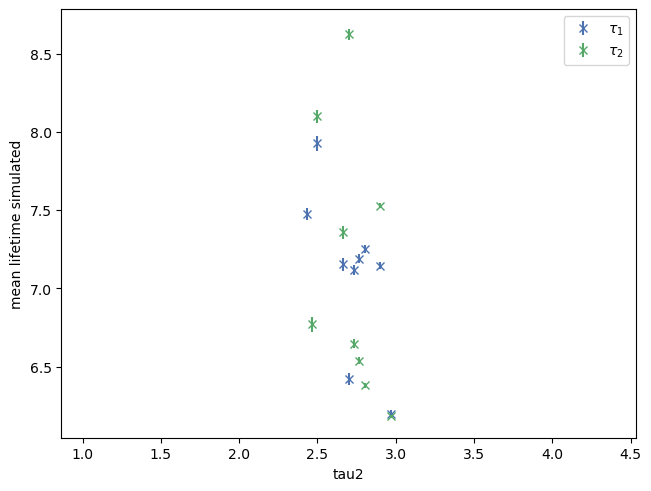

In [20]:
plt.figure()
plt.axis("equal")
plt.errorbar(tau_array,np.log(mean_ana[:,1]),yerr=std[:,1],fmt = 'x',label=rf'$\tau_{1}$')
plt.errorbar(tau_array,np.log(mean_ana[:,2]),yerr=std[:,2],fmt = 'x',label=rf'$\tau_{2}$')

plt.xlabel("tau2")
plt.ylabel("mean lifetime simulated")
plt.legend()
plt.show()

In [9]:
# simulation for different lifetimes
tau_array = np.linspace(2.43,3.07,20)
par_arr = np.zeros((20,100,3))
par_arr_f = np.zeros((20,20,100,3))
cri_arr = np.zeros(20)
for num in range(20):
    sec_i = num
    for i in range(len(tau_array)):
        tau2 = tau_array[i]
        EGFP = Phasor([0.497,0.503],[2.43,tau2])
        for j in range(len(EGFP.phasor_data)): #no background
            phasor = EGFP.phasor_data[j]
            par_arr[i,j] = phasor_solve_num_w(phasor,[EGFP.amp[0],*EGFP.tau])
    par_arr_f[num] = par_arr

C:\Users\xujia\AppData\Local\Temp\ipykernel_21992\3386848440.py:11: RuntimeWarning: overflow encountered in exp
  y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-EGFP.t / A_tau_arr[-1]) #last component
C:\Users\xujia\AppData\Local\Temp\ipykernel_21992\3386848440.py:11: RuntimeWarning: overflow encountered in multiply
  y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-EGFP.t / A_tau_arr[-1]) #last component
C:\Users\xujia\AppData\Local\Temp\ipykernel_21992\3386848440.py:10: RuntimeWarning: overflow encountered in exp
  y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential
C:\Users\xujia\AppData\Local\Temp\ipykernel_21992\3386848440.py:10: RuntimeWarning: overflow encountered in multiply
  y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential


In [ ]:
for num in range(20):
    cri_arr[num] = plot_w(par_arr_f[num],num)
    plt.savefig(f's_w{num}.pdf', format='pdf')

In [ ]:
y_mean = np.mean(cri_arr)
print(f"mean critical lifetime ratio: {y_mean}.")

plt.figure()
plt.ylim(0,4)
plt.axhline(y=y_mean,linestyle='-', label='mean')
plt.errorbar(np.linspace(0,20,20), cri_arr, yerr=0, fmt='x', label="critical lifetime ratio")
plt.xlabel("angular frequency selection")
plt.ylabel("critical lifetime ratio")
plt.legend()
plt.show()
plt.savefig('tau_w.pdf', format='pdf')